In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import differential_evolution, newton
from scipy.integrate import odeint, solve_ivp, quad
from scipy.special import kn
from astropy import constants as ct
import pandas as pd
from ipywidgets import interact,fixed,widgets,interactive
import warnings 
  
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

### Solution to the Boltzmann equation for WIMPs

In [2]:
g = 2
gstar = 106.75
MP = 2.4e18 #GeV
T0 = 2.725*ct.k_B.value/ct.e.value*1e-9
abundance = 0.12
gstars0 = 3.91
gstar0 = 3.38
s0 = 2*np.pi**2/45*gstars0*T0**3

In [3]:
def Yeq(x,mass,g):
    neq = g/(2*np.pi**2)*mass**3/x*kn(2,x)
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    return neq/s

def WIMPs(x,Y,mass,sigma,g):
    H = (np.pi**2*gstar/90)**0.5*(mass/x)**2/MP
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    dYdx = -sigma*s/(x*H)*(Y**2 - Yeq(x,mass,g)**2)
    return dYdx



$$
Y_0=\dfrac{3M_P^2\Omega_{DM}h^2(2.13\times10^{-42}\text{ GeV})^2}{ms_0}
$$


$$\Omega_{DM}h^2=\dfrac{Y_0ms_0}{3M_P^2(2.13\times 10^{-42}\text{ GeV})^2}$$

In [4]:
def Omega(m,sigma,model=WIMPs,g=2):
    m = 10.**m
    sigma = 10.**sigma
    xini = 0.1
    xfin = 1e4
    if model.__name__ == 'FIMPs':
        Yini = 0
    else:
        Yini = Yeq(xini, m, g)
    sol = solve_ivp(model, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(m,sigma,g))
    Y0 = sol.y[0][-1]
    s0 = 2*np.pi**2/45*gstars0*T0**3
    Omegah2 = Y0*m*s0/(3*MP**2*(2.13e-42)**2)
    if Omegah2 > 0:
        return Omegah2
    else:
        return 0

Omega = np.vectorize(Omega)

In [5]:
def graf1(mass,sigma,g):
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini,mass,g)
    xss = np.linspace(xini,30,1000)
    Yfin = 4.3e-10/mass
    sol = solve_ivp(WIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma))}',color='r')
    plt.loglog(xss,Yeq(xss,mass,g),label=r'$Y_{eq}$',color='b')
    plt.hlines(Yfin,xini,xfin,color='k',linestyle=':')
    plt.axhspan(0.9*Yfin,1.1*Yfin,0,1,color='yellow',alpha=0.5)
    #plt.ylim(2e-8,1e-2)
    plt.title('Boltzmann equation for WIMPs')
    plt.xlabel('x')
    plt.ylabel('Y')
    plt.grid()
    plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-3, max=3,
                                  step=0.0001, description='mass')
slider_sigma = widgets.FloatLogSlider(value=1e-12, base=10, min=-15, max=-7,
                                  step=0.1, description='sigma')
slider_g = widgets.FloatSlider(value=2, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot1 = interactive(graf1, mass=slider_mass, sigma=slider_sigma, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot1

interactive(children=(FloatLogSlider(value=0.001, description='mass', max=3.0, min=-3.0, step=0.0001), FloatLo…

### Exploring the parameter space

In [6]:
# Confidence level etc
alpha = 0.05
beta = 1. - alpha
critical_chi_sq = chi2.isf(alpha, 2)
critical_loglike = 0.5 * critical_chi_sq
min_chi_sq = 0.

In [7]:
# Scan settings
n_random_samples = int(1e7)
dim = 4
min_ = -5.
max_ = 5.
seed = 127


Likelihood function $\propto\mathcal{N}(\Omega_{obs},\Sigma)$. Thus, 

$$
\chi^2=\left(\dfrac{\Omega-\Omega_{obs}}{\Sigma}\right)^2
$$

with $\Omega_{obs}=0.12$ and $\Sigma=\sqrt{(0.1\Omega)^2+(0.001)^2}$

In [8]:
Omega_0 = 0.12
Sigma_th_rel = 0.1
Sigma_0 = 0.001

In [9]:
def chi_square(Omega):
    """
    Returns chi² function
    """
    Sigma = ((Sigma_th_rel*Omega)**2+(Sigma_0)**2)**0.5
    return ((Omega-Omega_0)/Sigma)**2

def loglike(Omega):
    """
    Returns log(L)
    """
    return -0.5*chi_square(Omega)

def samples_inside(x, chi_sq):
    """
    @returns Points from within delta chi-squared contour
    """
    delta_chi_sq = chi_sq - min_chi_sq
    inside = delta_chi_sq <= critical_chi_sq
    return x[:, inside]

In [10]:
def loglike_pars(P,model):
    m,sigma = P
    return loglike(Omega(m,sigma,model=model))
def chi_square_pars(P,model):
    m,sigma = P
    return chi_square(Omega(m,sigma,model=model))

In [11]:
bound_m = (-3,3)
bound_sigma = (-15,-7)

In [12]:
def de_scan(model,bound_m,bound_sigma,round_to_nearest=None):
    """
    @returns Points from within delta chi-squared contour from differential evolution
    and number of calls
    """
    bounds = [bound_m,bound_sigma]
    x = []
    chi_sq = []

    def objective(x_):
        """
        @returns Objective for DE that saves chi-squared and parameters
        """
        chi_sq_ = chi_square_pars(x_,model)
        chi_sq.append(chi_sq_)
        x.append(x_)
        return chi_sq_

    differential_evolution(objective, bounds,
                           strategy='rand1bin', maxiter=None,
                           popsize=50, tol=0.01, mutation=(0.7, 1.99999), recombination=0.15,
                           polish=False,seed=seed)

    if round_to_nearest is not None:
        len_x = len(x)
        keep_n = len_x - (len_x % round_to_nearest)
        x = x[:keep_n]
        chi_sq = chi_sq[:keep_n]

    return samples_inside(np.array(x).T, np.array(chi_sq)), len(x)

In [13]:
ms = np.linspace(*bound_m)
sigmas = np.linspace(*bound_sigma)

Ms, Sigmas = np.meshgrid(ms,sigmas)
Os = Omega(Ms,Sigmas)

In [14]:
def Omegah2_analytic(mass,sigma,n=0):
    A = np.log(0.038*(n+1)*g/(gstar**0.5)*(8*np.pi)**0.5*MP*mass*sigma)
    xf = A-(n+0.5)*np.log(A)
    omh = 1.07e9*(n+1)*xf**(n+1)/((gstar/gstar**0.5)*(8*np.pi)**0.5*MP*sigma)
    return omh

Omegah2_analytic = np.vectorize(Omegah2_analytic)

In [15]:
def obtain_optimal_params(model,bound_m,bound_sigma,path=None,descan=False):
    if descan:
        np.random.seed(seed)

        print('Running de_scan')
        t0 = time.time()
        x,calls = de_scan(model,bound_m,bound_sigma,round_to_nearest=1000)
        de_time = time.time() - t0
        print('Time = ', de_time)

        omegas_chi2 = Omega(x[0],x[1],model=model)

        df = pd.DataFrame()
        df['log(m)'] = pd.Series(x[0])
        df['log(sigma*v)'] = pd.Series(x[1])
        df['Omegah2'] = pd.Series(omegas_chi2)
        if model.__name__ == 'WIMPs':
            om_an = Omegah2_analytic(10.**x[0],10.**x[1])
            df['Omegah2_a'] = pd.Series(om_an)
            df['Delta'] = (df['Omegah2_a'] - df['Omegah2'])/df['Omegah2_a']*100

        filename = 'optimal_params_'+model.__name__+'.csv'

        df.to_csv(filename,index=False)

        return df

    else:
        df = pd.read_csv(path)
        return df

        

In [16]:
Os_an = Omegah2_analytic(10.**Ms,10.**Sigmas)

In [ ]:
df = obtain_optimal_params(WIMPs,bound_m,bound_sigma,descan=True)

In [17]:
path_WIMP = '/home/santiago/Trabajo_de_grado/Relic_density/optimal_params_WIMPs.csv'
df = obtain_optimal_params(WIMPs,bound_m,bound_sigma,descan=False,path=path_WIMP)

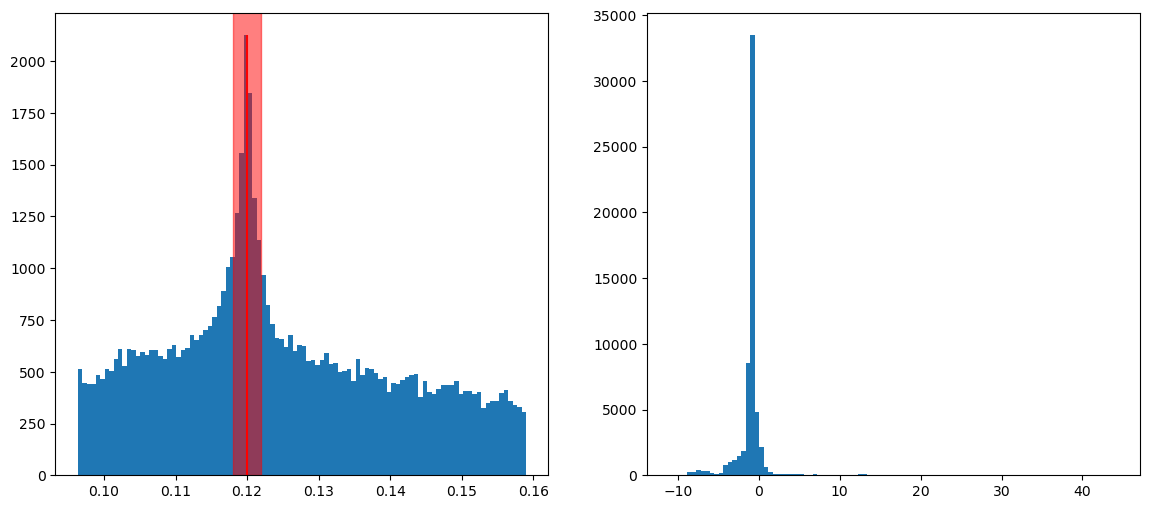

In [18]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

hist = ax[0].hist(df['Omegah2'],bins=100)
ax[0].vlines(0.12,0,hist[0].max(),color='r')
ax[0].axvspan(0.118,0.122,0,hist[0].max(),color='r',alpha=0.5)

hist2 = ax[1].hist(df['Delta'],bins=100)

Plotting de_scan


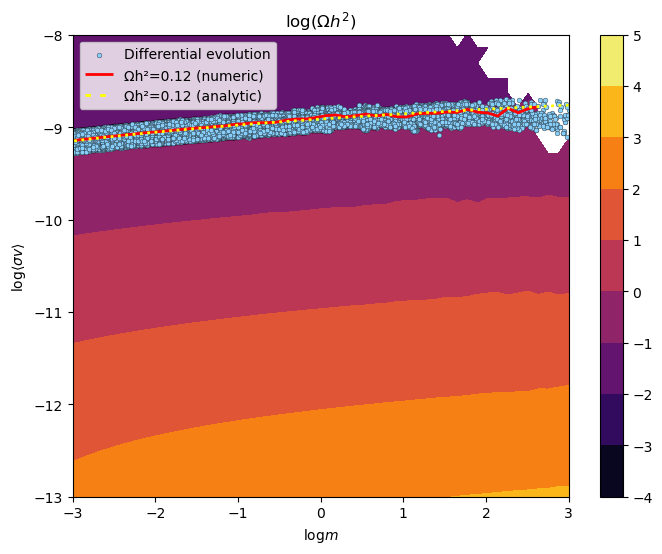

In [19]:
print('Plotting de_scan')
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms,Sigmas,np.log10(Os),cmap='inferno',)
de_scatter = ax.scatter(df['log(m)'], df['log(sigma*v)'], s=12, edgecolor='0.05',
                        linewidth=0.25, alpha=1.0, c='lightskyblue',label='Differential evolution')
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='red',linestyles='solid',linewidths=2)
CS2l = ax.contour(Ms,Sigmas,np.log10(Os_an),levels=[np.log10(0.12),],colors='yellow',linestyles='dotted',linewidths=2)
cbar = fig.colorbar(CS)

ax.legend()

h0,_ = de_scatter.legend_elements(prop='sizes',color=de_scatter.cmap(1.5))
h1,_ = CSl.legend_elements()
h2,_ = CS2l.legend_elements()

ax.legend([de_scatter]+h1+h2,['Differential evolution','Ωh²=0.12 (numeric)','Ωh²=0.12 (analytic)'])

#ax.add_artist(leg2)

ax.set_title(r'$\mathrm{log}(\Omega h^2)$')
ax.set_ylim((-13,-8))
ax.set_xlabel(r'$\mathrm{log}m$')
ax.set_ylabel(r'$\mathrm{log}\langle\sigma v\rangle$')
plt.savefig('omegah2_WIMPs.pdf')
plt.show()

### Parametrization of WIMP cross section

In [20]:
def WIMPs_par(x,Y,mass,alpha,g):
    sigma = alpha**2/mass**2
    H = (np.pi**2*gstar/90)**0.5*(mass/x)**2/MP
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    dYdx = -sigma*s/(x*H)*(Y**2 - Yeq(x,mass,g)**2)
    return dYdx

In [21]:
def graf5(mass,alpha,g):
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini,mass,g)
    xss = np.linspace(xini,30,1000)
    sol = solve_ivp(WIMPs_par, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,alpha,g))
    sigma = alpha**2/mass**2
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma))}')
    plt.loglog(xss,Yeq(xss,mass,g))
    #plt.hlines(4.3e-10/mass,xini,xfin,color='k',linestyle=':')
    plt.grid()
    plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-3, max=5,
                                  step=0.0001, description='mass')
slider_alpha = widgets.FloatLogSlider(value=1e-2, base=10, min=-5, max=0,
                                  step=0.1, description='alpha')
slider_g = widgets.FloatSlider(value=2, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot5 = interactive(graf5, mass=slider_mass, alpha=slider_alpha, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot5

interactive(children=(FloatLogSlider(value=0.001, description='mass', max=5.0, min=-3.0, step=0.0001), FloatLo…

In [22]:
Omega_par = lambda m,alpha: Omegah2_analytic(10.**m,(10.**alpha/10.**m)**2)

In [23]:
ms = np.linspace(-3,5)
alphas = np.linspace(-5,0)

Ms, Alphas = np.meshgrid(ms,alphas)

In [24]:
Os_par = Omega_par(Ms,Alphas)

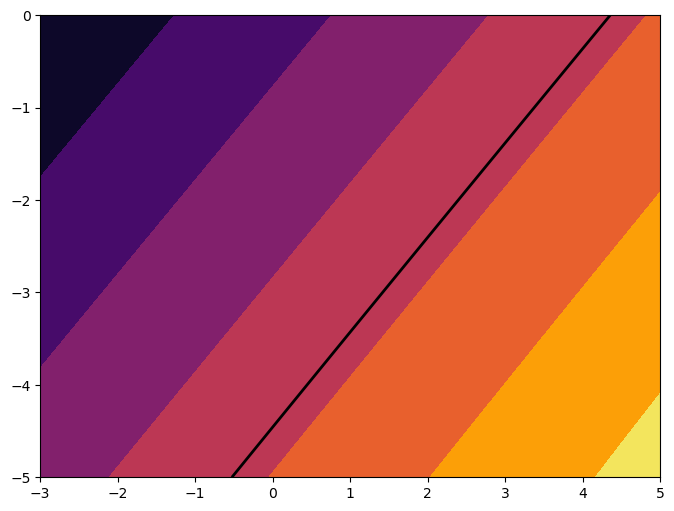

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms,Alphas,np.log10(Os_par),cmap='inferno',)
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='k',linestyles='solid',linewidths=2)

In [26]:
p = CSl.collections[0].get_paths()[0]
v = p.vertices
d = pd.DataFrame(v,columns=['logm','loga'])
Mmax = 10.**d[d['loga']==0]['logm'].values[0]

### FIMPs

In [27]:
def FIMPs(x,Y,mass,sigma,g):
    a = 45/(4*np.pi**4*gstar)
    b = (2/15)*(10*gstar)**0.5*MP
    return sigma*a**2*b*mass*g**2*(x*kn(2,x))**2

FIMPs = np.vectorize(FIMPs)

In [28]:
def FIMPs_an(x,mass,sigma,g,xini=0.1,integval=None):
    a = 45/(4*np.pi**4*gstar)
    b = (2/15)*(10*gstar)**0.5*MP
    if integval:
        integ = integval
    else:
        integ = quad(lambda x:(x*kn(2,x))**2,xini,x)[0]
    return sigma*a**2*b*mass*g**2*integ

FIMPs_an = np.vectorize(FIMPs_an)

In [29]:
def graf4(mass,sigma,g):
    xini = 0.1
    xfin = 1e4
    Yini = 0.
    xss = np.linspace(xini,30,1000)
    xs = np.logspace(np.log10(xini),np.log10(xfin),1000)
    an = FIMPs_an(xs,mass,sigma,g,xini)
    sol = solve_ivp(FIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma),model=FIMPs)}')
    plt.loglog(xss,Yeq(xss,mass,g))
    plt.loglog(xs,an)
    plt.hlines(4.3e-10/mass,xini,xfin,color='k',linestyle=':')
    plt.grid()
    plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-6, max=3,
                                  step=0.0001, description='mass')
slider_sigma = widgets.FloatLogSlider(value=1e-12, base=10, min=-32, max=-12,
                                  step=0.1, description='sigma')
slider_g = widgets.FloatSlider(value=2, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot4 = interactive(graf4, mass=slider_mass, sigma=slider_sigma, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot4

interactive(children=(FloatLogSlider(value=0.001, description='mass', max=3.0, min=-6.0, step=0.0001), FloatLo…

In [30]:
ms = np.linspace(-6,3)
sigmas = np.linspace(-32,-12)

Ms, Sigmas = np.meshgrid(ms,sigmas)

In [31]:
Om_FIMP = Omega(Ms,Sigmas,model=FIMPs)

In [32]:
bound_m_F = (-6,3)
bound_sigma_F = (-32,-12)

In [ ]:
df_FIMP = obtain_optimal_params(FIMPs,bound_m_F,bound_sigma_F,descan=True)

In [33]:
path_FIMP = '/home/santiago/Trabajo_de_grado/Relic_density/optimal_params_FIMPs.csv'
df_FIMP = obtain_optimal_params(WIMPs,bound_m,bound_sigma,descan=False,path=path_FIMP)

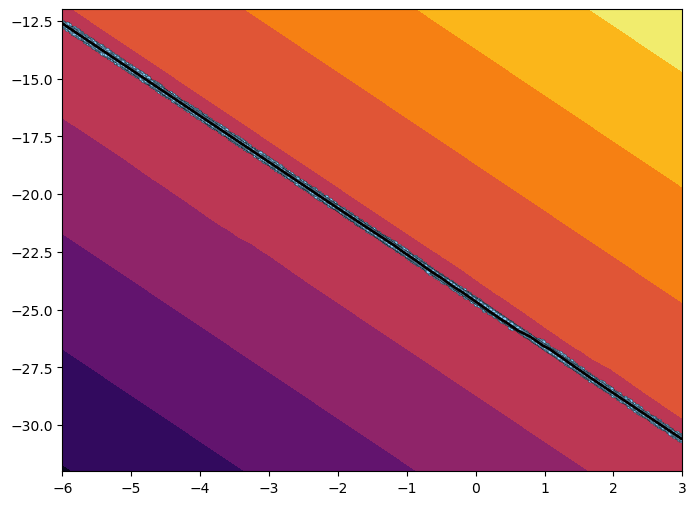

In [34]:
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms,Sigmas,np.log10(Om_FIMP),cmap='inferno',)
de_scatter = ax.scatter(df_FIMP['log(m)'], df_FIMP['log(sigma*v)'], s=12, edgecolor='0.05',
                        linewidth=0.25, alpha=1.0, c='lightskyblue',label='Differential evolution')
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='k',linestyles='solid',linewidths=2)

### WIMPs semi-annihilation and SIMPs

In [35]:
def WIMPs_SA(x,Y,mass,sigma,g):
    H = (np.pi**2*gstar/90)**0.5*(mass/x)**2/MP
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    dYdx = -sigma*s/(x*H)*(Y**2 - Y*Yeq(x,mass,g))
    return dYdx

def SIMPs(x,Y,mass,sigma,g):
    H = (np.pi**2*gstar/90)**0.5*(mass/x)**2/MP
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    dYdx = -sigma*s**2/(x*H)*(Y**3 - Y**2*Yeq(x,mass,g))
    return dYdx

In [36]:
def graf2(mass,sigma,g):
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini,mass,g)
    xss = np.linspace(xini,30,1000)
    sol = solve_ivp(SIMPs, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma),model=SIMPs)}')
    plt.loglog(xss,Yeq(xss,mass,g))
    plt.hlines(4.3e-10/mass,xini,xfin,color='k',linestyle=':')
    plt.grid()
    plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-3, max=4,
                                  step=0.0001, description='mass')
slider_sigma = widgets.FloatLogSlider(value=1e-3, base=10, min=-3, max=7,
                                  step=0.1, description='sigma')
slider_g = widgets.FloatSlider(value=2, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot2 = interactive(graf2, mass=slider_mass, sigma=slider_sigma, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot2

interactive(children=(FloatLogSlider(value=0.001, description='mass', min=-3.0, step=0.0001), FloatLogSlider(v…

In [37]:
def graf3(mass,sigma,g):
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini,mass,g)
    xss = np.linspace(xini,30,1000)
    sol = solve_ivp(WIMPs_SA, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma))}')
    plt.loglog(xss,Yeq(xss,mass,g))
    plt.hlines(4.3e-10/mass,xini,xfin,color='k',linestyle=':')
    plt.grid()
    plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-4, max=2,
                                  step=0.0001, description='mass')
slider_sigma = widgets.FloatLogSlider(value=1e-12, base=10, min=-10, max=-3,
                                  step=0.1, description='sigma')
slider_g = widgets.FloatSlider(value=2, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot3 = interactive(graf3, mass=slider_mass, sigma=slider_sigma, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot3

interactive(children=(FloatLogSlider(value=0.001, description='mass', max=2.0, min=-4.0, step=0.0001), FloatLo…

In [40]:
bound_m_S = (-4,3)
bound_sigma_S = (-3,8)

In [41]:
df_SIMP = obtain_optimal_params(SIMPs,bound_m_S,bound_sigma_S,descan=True)

Running de_scan
Time =  54055.06326889992


In [43]:
ms = np.linspace(-6,3)
sigmas = np.linspace(-3,8)

Ms, Sigmas = np.meshgrid(ms,sigmas)

Om_SIMP = Omega(Ms,Sigmas,model=SIMPs)

In [40]:
path_SIMP = '/home/santiago/Trabajo_de_grado/Relic_density/optimal_params_SIMPs.csv'
df_SIMP = obtain_optimal_params(WIMPs,bound_m,bound_sigma,descan=False,path=path_SIMP)

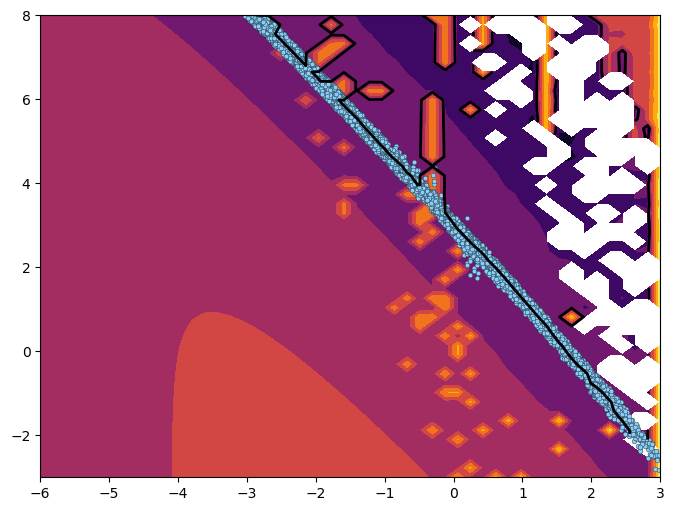

In [44]:
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms,Sigmas,np.log10(Om_SIMP),cmap='inferno',)
de_scatter = ax.scatter(df_SIMP['log(m)'], df_SIMP['log(sigma*v)'], s=12, edgecolor='0.05',
                        linewidth=0.25, alpha=1.0, c='lightskyblue',label='Differential evolution')
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='k',linestyles='solid',linewidths=2)
#ax.set(xlim=(-3,2),ylim=(-3,8))


### Parameterization of SIMP cross section

In [45]:
def SIMPs_par(x,Y,mass,alpha,g):
    sigma = alpha**3/mass**5
    H = (np.pi**2*gstar/90)**0.5*(mass/x)**2/MP
    s = 2*np.pi**2/45*gstar*(mass/x)**3
    dYdx = -sigma*s**2/(x*H)*(Y**3 - Y**2*Yeq(x,mass,g))
    return dYdx

In [46]:
def graf6(mass,alpha,g):
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini,mass,g)
    xss = np.linspace(xini,30,1000)
    sol = solve_ivp(SIMPs_par, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,alpha,g))
    sigma = alpha**3/mass**5
    plt.loglog(sol.t,sol.y[0],label=f'Ωh²={Omega(np.log10(mass),np.log10(sigma),model=SIMPs)}')
    plt.loglog(xss,Yeq(xss,mass,g))
    plt.hlines(4.3e-10/mass,xini,xfin,color='k',linestyle=':')
    plt.grid()
    plt.legend()
    plt.show()
    
slider_mass = widgets.FloatLogSlider(value=1e-3, base=10, min=-6, max=3,
                                  step=0.0001, description='mass')
slider_alpha = widgets.FloatLogSlider(value=1e-2, base=10, min=-5, max=0,
                                  step=0.1, description='alpha')
slider_g = widgets.FloatSlider(value=2, min=1, max=3,
                                  step=1, description='g')
# Crea la función interactiva

interactive_plot6 = interactive(graf6, mass=slider_mass, alpha=slider_alpha, g=slider_g,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot6

interactive(children=(FloatLogSlider(value=0.001, description='mass', max=3.0, min=-6.0, step=0.0001), FloatLo…

In [47]:
Omega_par_SIMP = lambda m,alpha: Omega(m,3*alpha-5*m,model=SIMPs)

In [48]:
ms = np.linspace(-6,3)
alphas = np.linspace(-5,0)

Ms, Alphas = np.meshgrid(ms,alphas)

In [50]:
Om_par_S = Omega_par_SIMP(Ms,Alphas)

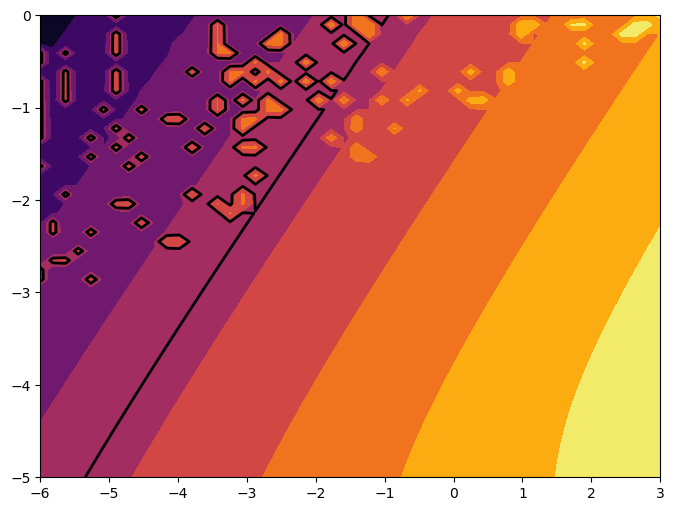

In [52]:
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms,Alphas,np.log10(Om_par_S),cmap='inferno',)
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='k',linestyles='solid',linewidths=2)

$$Y_\infty=\sqrt{\dfrac{2}{\lambda}}x_f^2$$

where $\lambda=-\langle\sigma v^2\rangle\dfrac{\alpha^2}{\beta}m^4,~\alpha=\dfrac{2\pi^2}{45}g_{\star S},~\beta=\sqrt{\dfrac{\pi^2}{90M_P^2}g_\star}$ and $x_f$ is the solution to $e^{-2x_f}=\dfrac{x_f^2}{k^2\lambda c(c+1)^2}$, $k=0.145\dfrac{g}{g_{\star S}}$

$$\Omega_{DM}h^2=\dfrac{Y_0ms_0}{3M_P^2(2.13\times 10^{-42}\text{ GeV})^2}$$

In [53]:
def Omega0_SIMP(m,sigma,g,const):
    alpha = 2*np.pi**2/45*gstar
    beta = (np.pi**2/(90*MP**2)*gstar)**0.5
    lam = sigma*alpha**2/beta*m**4
    k = 0.145*g/gstar
    func = lambda xf_: np.exp(-2*xf_)*(k**2*lam*const)-xf_**2
    xf = newton(func,10,maxiter=2000)
    Yinf = (2/lam)**0.5*xf**2
    return Yinf*m*s0/(3*MP**2*(2.13e-42)**2)

Omega0_SIMP = np.vectorize(Omega0_SIMP)

In [54]:
def find_const(mass,sigma,g):
    func = lambda k: Omega(np.log10(mass),np.log10(sigma),model=SIMPs,g=g)-Omega0_SIMP(mass,sigma,g,k)
    try:
        const = newton(func,10,maxiter=2000)
    except RuntimeError:
        const= np.nan
    return const

find_const = np.vectorize(find_const)

In [55]:
len(ms)*len(sigmas)*2/60

83.33333333333333

In [56]:
Om_th = Omega0_SIMP(10.**Ms,10.**Sigmas,2,5)


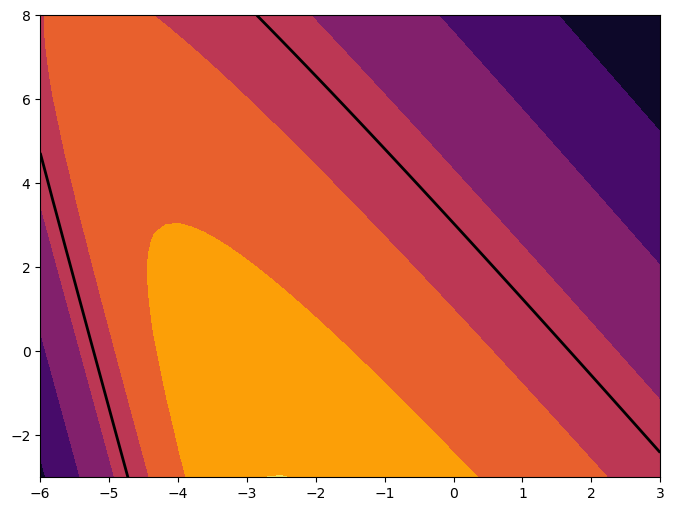

In [57]:
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms,Sigmas,np.log10(Om_th),cmap='inferno',)
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='k',linestyles='solid',linewidths=2)


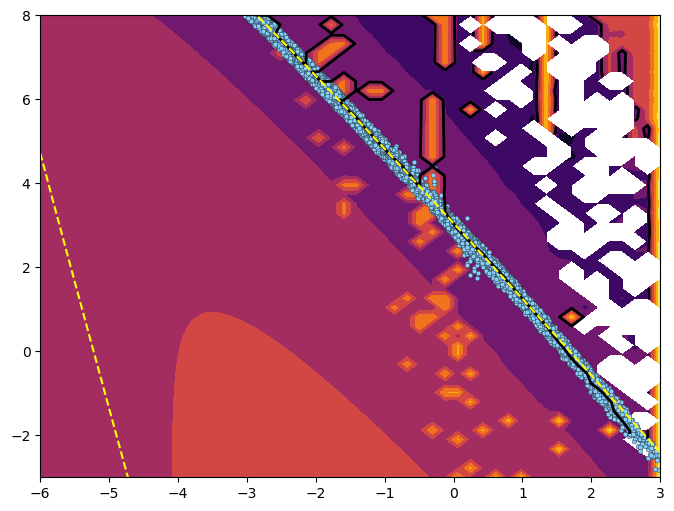

In [58]:
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(Ms,Sigmas,np.log10(Om_SIMP),cmap='inferno',)
de_scatter = ax.scatter(df_SIMP['log(m)'], df_SIMP['log(sigma*v)'], s=12, edgecolor='0.05',
                        linewidth=0.25, alpha=1.0, c='lightskyblue',label='Differential evolution')
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='k',linestyles='solid',linewidths=2)
CS2l = ax.contour(Ms,Sigmas,np.log10(Om_th),levels=[np.log10(0.12),],colors='yellow')
#ax.set(xlim=(-3,2),ylim=(-3,8))


### Long-lived relativistic particle

$$\begin{align*}
\dfrac{\mathrm{d}n_\phi}{\mathrm{d}t}+3Hn_\phi&=-\Gamma_\phi n_\phi\\
\dfrac{\mathrm{d}\rho_R}{\mathrm{d}t}+4H\rho_R&=+\Gamma_\phi n_\phi m_\phi\\
H&=\sqrt{\dfrac{\rho_R+m_\phi n_\phi}{3M_P^2}}
\end{align*}$$

Using $R=\rho_Ra^4$ and $\Phi=n_\phi a^3$:

$$\begin{align*}
\dfrac{\mathrm{d}\Phi}{\mathrm{d}t}&=-\Gamma_\phi\Phi\\
\dfrac{\mathrm{d}R}{\mathrm{d}t}&=\Gamma_\phi\Phi am_\phi\\
\dfrac{\mathrm{d}a}{\mathrm{d}t}&=\sqrt{\dfrac{R+\Phi m_\phi a}{3M_P^2}}a^3\\
\end{align*}

In [90]:
def dVda(a,V,mass,Gamma):
    Phi, R = V
    H = ((R+Phi*a*mass)/(3*MP**2))**0.5*a**-2
    dPhida = -Gamma*Phi/(a*H)
    dRda = Gamma*mass*Phi/H
    dVda = [dPhida,dRda]
    return dVda

```
def graf3(mass,sigma,g):
    xini = 0.1
    xfin = 1e4
    Yini = Yeq(xini,mass,g)
    xss = np.linspace(xini,30,1000)
    sol = solve_ivp(WIMPs_SA, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(mass,sigma,g))
```

In [119]:
a0 = 1
afin = 1e10
V0 = [100.,0.]
sol = solve_ivp(dVda,[a0,afin],V0,method='BDF',rtol=1e-8,atol=1e-10,args=(10,1e-24))


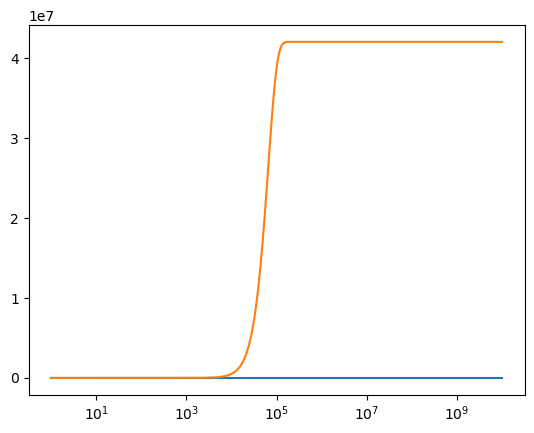

In [120]:
plt.semilogx(sol.t,sol.y[0])
plt.semilogx(sol.t,sol.y[1])

In [121]:
from scipy.integrate import solve_ivp
import numpy as np

# Define the equations for Φ (Phi) and R (Radiation)
def boltzmann_equations(log_a, y, Gamma_phi, m_phi, M_p):
    a = np.exp(log_a)  # Convert log(a) back to a
    Phi, R = y  # Unpack variables
    H = np.sqrt((R + m_phi * Phi) / (3 * M_p**2))  # Friedmann equation
    dPhi_dloga = -Gamma_phi * Phi / H
    dR_dloga = (Gamma_phi * Phi * m_phi) / H
    return [dPhi_dloga, dR_dloga]

# Parameters
Gamma_phi = 1e-24  # Decay width in GeV
m_phi = 10         # Mass of phi in GeV
M_p = 1.22e19      # Planck mass in GeV
a_ini = 1
a_final = 1e5

# Initial conditions: Phi_ini and R_ini
Phi_ini = 1e-4  # Example value
R_ini = 0

# Solve the system
sol = solve_ivp(
    boltzmann_equations,
    t_span=[np.log(a_ini), np.log(a_final)],
    y0=[Phi_ini, R_ini],
    args=(Gamma_phi, m_phi, M_p),
    method='RK45',
    t_eval=np.linspace(np.log(a_ini), np.log(a_final), 500)
)


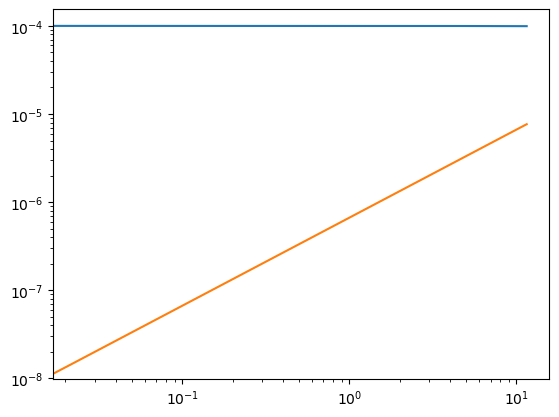

In [124]:
plt.loglog(sol.t,sol.y[0])
plt.loglog(sol.t,sol.y[1])